In [ ]:
library(DropletUtils)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
library(hdf5r) 
library(future)
library(RColorBrewer)
library(dplyr)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg38)
library(glue)
library(harmony)
library(matrixStats)
library(scales)
library(biomaRt)
library(curl)
library(goseq)
library(httr)
library(Scillus)
library(TFBSTools)
library(JASPAR2020)
library(ggridges)
library(ggrepel)
library(ggsignif)
library(qusage)
library(tidyverse)
library(lme4)
library(lmerTest)
library(dplyr)
httr::set_config(config(ssl_verifypeer = 0L))
set.seed(1234)
setwd('data/inhouse_wu_long_yu')

In [ ]:
source('../../snatac-rcc-manuscript-data/functions.r')

# Figure 4A: Correlation between RNA-derived IFN signaling and ATAC-derived IFN signaling in multiome sample tumor cells

- Read in RNA-derived IFN signaling scores from Cytosig
    - Note: this was calculated for all RNA and ATAC QC passing multiome tumor cells
- Read in Seurat object with ATAC data

In [4]:
## Cytosig scores - ran on expression data from tumor cells that passed RNA and ATAC QC
coefs = read.table('scte/cytosig/output.Coef', sep = '\t', check.names = FALSE)
coefs = data.frame(t(coefs))

## ATAC object that we will add the cytosig scores to
allcells = readRDS('allcells/seurat_obj/integrated_allcohorts_seuratobj_geneactivity_lsi_metadata_qc_motifs_annotated_detailed.rds')

Subset ATAC object to cells w cytosig run, add cytosig metadata

- Cytosig barcode prefixes match the convention used in the RNA object, not the ATAC object. Since we want to add these to the ATAC object, we need to swap out these prefixes. (e.g replace 0600855_T3_MO_ with CCG1114e_0600855_T3_B1_multiome)

In [5]:
# Prefixes to replace
old_strings <- c('0600855_T3_MO', '0600876_T1_MO', '0600913_T1_MO', '0600915_T1_MO')
# Replacements
new_strings <- c('CCG1114e_0600855_T3_B1_multiome', 'CCG1114e_0600876_T1_G1_multiome', 'CCG1114e_0600913_T1_E1_multiome', 'CCG1114e_0600915_T1_H3_multiome')

# Create a named vector for str_replace_all
replacement_vector <- setNames(new_strings, old_strings)

# Apply the replacements
coefs$old_barcodes = row.names(coefs)
coefs = coefs %>%
  mutate(new_barcodes = str_replace_all(old_barcodes, replacement_vector))
cytsig_barcodes_multiomemapped = coefs$new_barcodes
row.names(coefs) = coefs$new_barcodes

In [6]:
# subset ATAC object to multiome samples w cytosig scores, and add the relevant cytosig score metadata
tum_w_cytosig = subset(allcells, cells = cytsig_barcodes_multiomemapped)
tum_w_cytosig = AddMetaData(tum_w_cytosig, metadata = coefs %>% dplyr::select(c('IFN1','IFNG')) %>% rename('IFN1_RNA' = 'IFN1', 'IFNG_RNA' = 'IFNG'))

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_50dims_ to umap50dims_"


**Signature scoring with IFN1 and IFNG-associated peak sets**

Peaks are from the mixed effects model associating a given peak's accessibility with cytosig derived IFN scores. We only tested peaks called in the tumor cluster and >5% pct.accessible (5% w/ non-zero accessibility, from dotplot) n = 80768 tests. We ran the below model for each peak.

`lmer(pk_accessibility ~ ifn_score + seq_depth + (1|sample), data = data_for_model)`

Results from mixed effects model in Supp table 4, sheet A & B.

In [7]:
# Signature scoring with set of peaks nominally significant with positive coefficient
ifn1_me = readRDS('scte/cytosig/ifn1_sample_fivep_mixedeffects_assoc_peaks.RDS')
ifn1_me$p.value = ifn1_me[,5]
ifn1_me$feature = as.character(ifn1_me$feature)
ifn1_me_sig = ifn1_me %>% filter((p.value < 0.05) & (Estimate > 0))
sig = calculate_signature_scores(seurat_object = tum_w_cytosig, sig_peak_set = ifn1_me_sig$feature, pct.open = 0.05, final_score_name = 'IFN1_ATAC')
tum_w_cytosig = AddMetaData(tum_w_cytosig, metadata = sig)


# Signature scoring with set of peaks nominally significant with positive coefficient
ifng_me = readRDS('scte/cytosig/ifng_sample_fivep_mixedeffects_assoc_peaks.RDS')
ifng_me$p.value = ifng_me[,5]
ifng_me$feature = as.character(ifng_me$feature)
ifng_me_sig = ifng_me %>% filter((p.value < 0.05) & (Estimate > 0))
sig = calculate_signature_scores(seurat_object = tum_w_cytosig, sig_peak_set = ifng_me_sig$feature, pct.open = 0.05, final_score_name = 'IFNG_ATAC')
tum_w_cytosig = AddMetaData(tum_w_cytosig, metadata = sig)

Matching GC.percent distribution

Matching GC.percent distribution



Plot results for IFN1

`geom_smooth()` using formula = 'y ~ x'


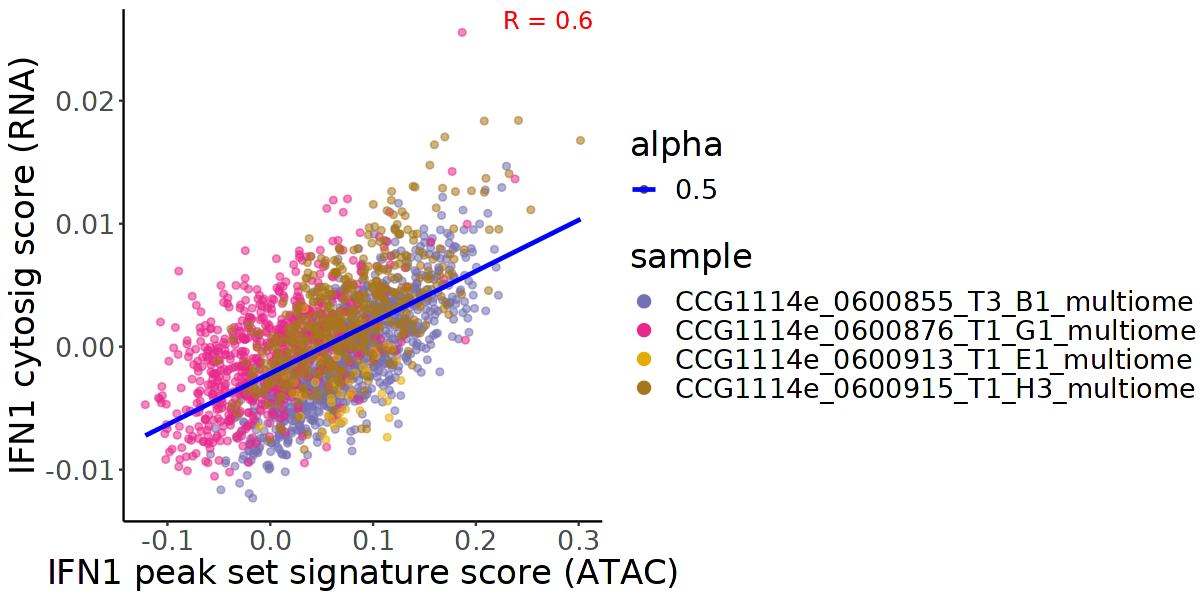

In [8]:
corr_coef <- cor(tum_w_cytosig@meta.data$IFN1_ATAC, tum_w_cytosig@meta.data$IFN1_RNA)

options(repr.plot.width=10, repr.plot.height=5)
ggplot(tum_w_cytosig@meta.data, aes(x = IFN1_ATAC, y = IFN1_RNA, color = sample, alpha = 0.5)) + 
    geom_point()+ 
    geom_smooth(method = "lm", color = "blue", se = FALSE)+ annotate("text", x = Inf, y = Inf, label = paste("R =", round(corr_coef, 2)), hjust = 1.1, vjust = 1.1, size = 5, color = "red") +
    theme_classic() +
    scale_color_manual(values = c('#7570b3','#e7298a','#e6ab02', '#a6761d')) +
    theme(text = element_text(size =20))+ guides(colour = guide_legend(override.aes = list(size=3))) +
    xlab('IFN1 peak set signature score (ATAC)') +
    ylab('IFN1 cytosig score (RNA)')

Plot results for IFNG

`geom_smooth()` using formula = 'y ~ x'


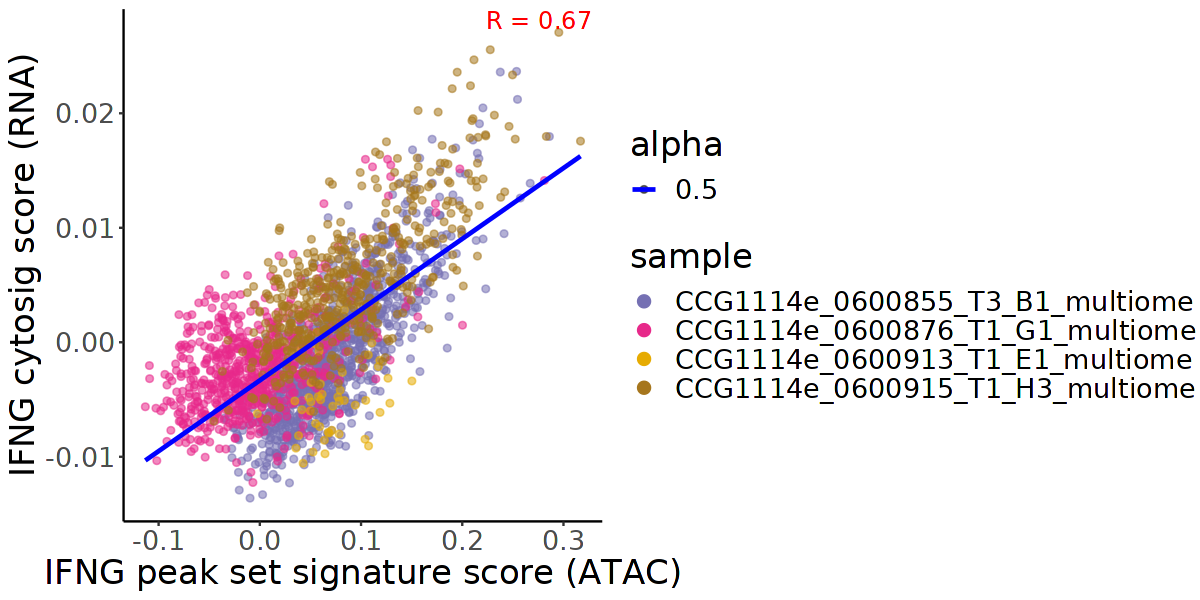

In [9]:
corr_coef <- cor(tum_w_cytosig@meta.data$IFNG_ATAC, tum_w_cytosig@meta.data$IFNG_RNA)

options(repr.plot.width=10, repr.plot.height=5)
ggplot(tum_w_cytosig@meta.data, aes(x = IFNG_ATAC, y = IFNG_RNA, color = sample, alpha = 0.5)) + 
    geom_point()+ 
    geom_smooth(method = "lm", color = "blue", se = FALSE)+ annotate("text", x = Inf, y = Inf, label = paste("R =", round(corr_coef, 2)), hjust = 1.1, vjust = 1.1, size = 5, color = "red") +
    theme_classic() +
    scale_color_manual(values = c('#7570b3','#e7298a','#e6ab02', '#a6761d')) +
    theme(text = element_text(size =20))+ guides(colour = guide_legend(override.aes = list(size=3))) +
    xlab('IFNG peak set signature score (ATAC)') +
    ylab('IFNG cytosig score (RNA)')

# Figure 4B: TF motif binding site enrichment in IFN1 and IFNG-associated peak sets

**IFN1 peak set**

Motif enrichment results in Supp table 4, sheet C.

In [10]:
DefaultAssay(tum_w_cytosig) = 'ATAC'

# Define a set of background peaks
## Find peaks that are open in a significant portion of cells
percent_to_num_cells = ceiling(nrow(tum_w_cytosig@meta.data) * 0.1)
open_peaks <- AccessiblePeaks(tum_w_cytosig, min.cells = percent_to_num_cells)

## Match the overall GC content in the peak set
meta.feature <- GetAssayData(tum_w_cytosig, assay = "ATAC", slot = "meta.features")
peaks_matched <- MatchRegionStats(
meta.feature = meta.feature[open_peaks, ],
query.feature = meta.feature[ifn1_me_sig$feature, ]
)

# Determine enrichment of motifs in peak set - Hypergeometric test
enriched.motifs <- FindMotifs(
    object = tum_w_cytosig,
    features = ifn1_me_sig$feature,
    background = peaks_matched
    )
write.table(enriched.motifs %>% filter(p.adjust < 0.05),
           file = '../../snatac-rcc-manuscript-data/s4c_IFN1_tfmotifs.txt', sep = '\t', quote = F, row.names = F, col.names = T)


Matching GC.percent distribution

Testing motif enrichment in 3148 regions



In [11]:
min((enriched.motifs %>% filter(p.adjust < 0.05))$fold.enrichment)
max((enriched.motifs %>% filter(p.adjust < 0.05))$fold.enrichment)

[1] 1.030735

[1] 1.968501

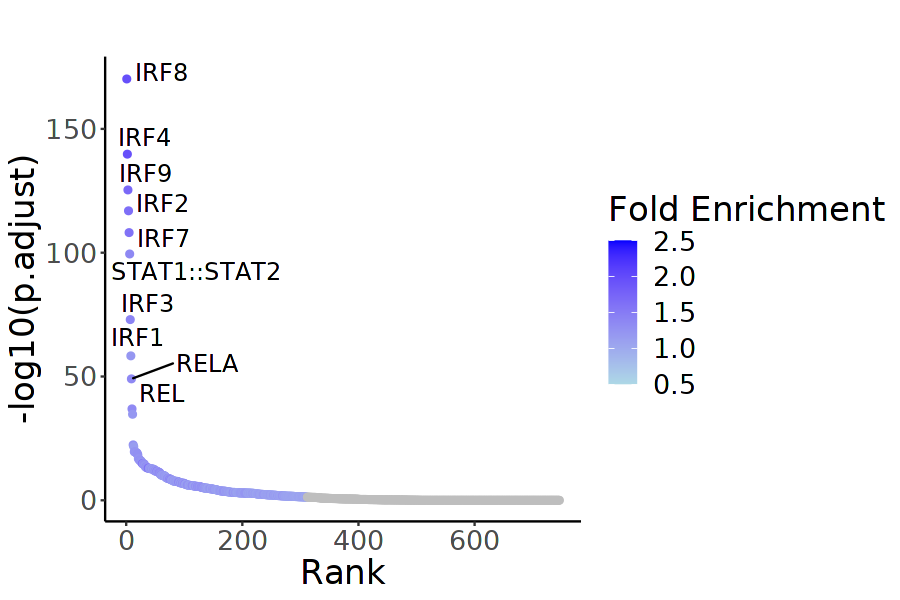

In [13]:
options(repr.plot.width=7.5, repr.plot.height=5)
create_motif_significance_plot(enriched.motifs, n_annotate = 10, color_gradient_limits = c(0.5,2.5) ) + ggtitle("")

**IFNG peak set**

Motif enrichment results in Supp table 4, sheet D.

In [12]:
DefaultAssay(tum_w_cytosig) = 'ATAC'

# Define a set of background peaks
## Find peaks that are open in a significant portion of cells
percent_to_num_cells = ceiling(nrow(tum_w_cytosig@meta.data) * 0.1)
open_peaks <- AccessiblePeaks(tum_w_cytosig, min.cells = percent_to_num_cells)

## Match the overall GC content in the peak set
meta.feature <- GetAssayData(tum_w_cytosig, assay = "ATAC", slot = "meta.features")
peaks_matched <- MatchRegionStats(
meta.feature = meta.feature[open_peaks, ],
query.feature = meta.feature[ifng_me_sig$feature, ]
)

# Determine enrichment of motifs in peak set - Hypergeometric test
enriched.motifs <- FindMotifs(
    object = tum_w_cytosig,
    features = ifng_me_sig$feature,
    background = peaks_matched
    )
write.table(enriched.motifs %>% filter(p.adjust < 0.05),
           file = '../../snatac-rcc-manuscript-data/s4d_IFNG_tfmotifs.txt', sep = '\t', quote = F, row.names = F, col.names = T)


Matching GC.percent distribution

Testing motif enrichment in 3812 regions



In [13]:
min((enriched.motifs %>% filter(p.adjust < 0.05))$fold.enrichment)
max((enriched.motifs %>% filter(p.adjust < 0.05))$fold.enrichment)

[1] 1.024575

[1] 2.293465

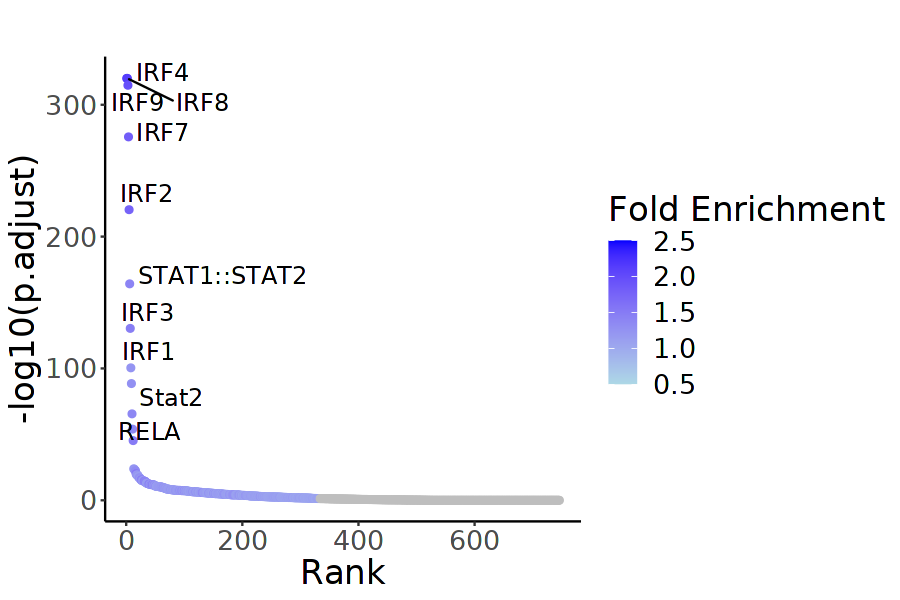

In [19]:
options(repr.plot.width=7.5, repr.plot.height=5)
create_motif_significance_plot(enriched.motifs, n_annotate = 10, color_gradient_limits = c(0.5,2.5)) + ggtitle("")

# Figure 4C: Top GO BP and MSigDB pathways in IFN1 and IFNG-associated peak sets

Read in IFN1 peak set GREAT pathway results. Results in Supp table 4, sheet E.

In [25]:
# Wrangling IFN1 peak set pathway results
header = read.table('allcells/tumor/great/greatExportAll_forheader.tsv', fill = TRUE, sep = "\t", quote = "", row.names = NULL)
header = unlist(unname(t(header[1,])[,1]))

great_results = read.table('scte/cytosig/GREAT/ifn1_mixedeffects_nominalp_peaks_RESULTS.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]

# Subset results using filters implemented on GREAT website
keep = c('GO Biological Process', 'MSigDB Pathway')
great_results$Ontology2 = great_results$Ontology
great_results$Desc = paste0(great_results$Desc,'T1')
ifn1_great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) %>%
group_by(Ontology) %>%
  arrange(BinomP) %>%
  slice_head(n = 5)

Read in IFNG peak set GREAT pathway results. Results in Supp table 4, sheet E.

In [26]:
# Wrangling IFNG peak set pathway results
great_results = read.table('scte/cytosig/GREAT/ifng_mixedeffects_nominalp_peaks_RESULTS.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]

# Subset results using filters implemented on GREAT website
great_results$Ontology2 = great_results$Ontology
great_results$Desc = paste0(great_results$Desc,'T2')
ifng_great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) %>%
group_by(Ontology) %>%
  arrange(BinomP) %>%
  slice_head(n = 5)

great_results = dplyr::bind_rows(ifn1_great_results, ifng_great_results)

In [27]:
great_results$Ontology2 = 'Same'

First 10 are pathways enriched in IFN1 peak set. Split by 5 from GO BP and 5 from MSigDB. Last 10 are enriched in IFNG peak set, and split the same. 

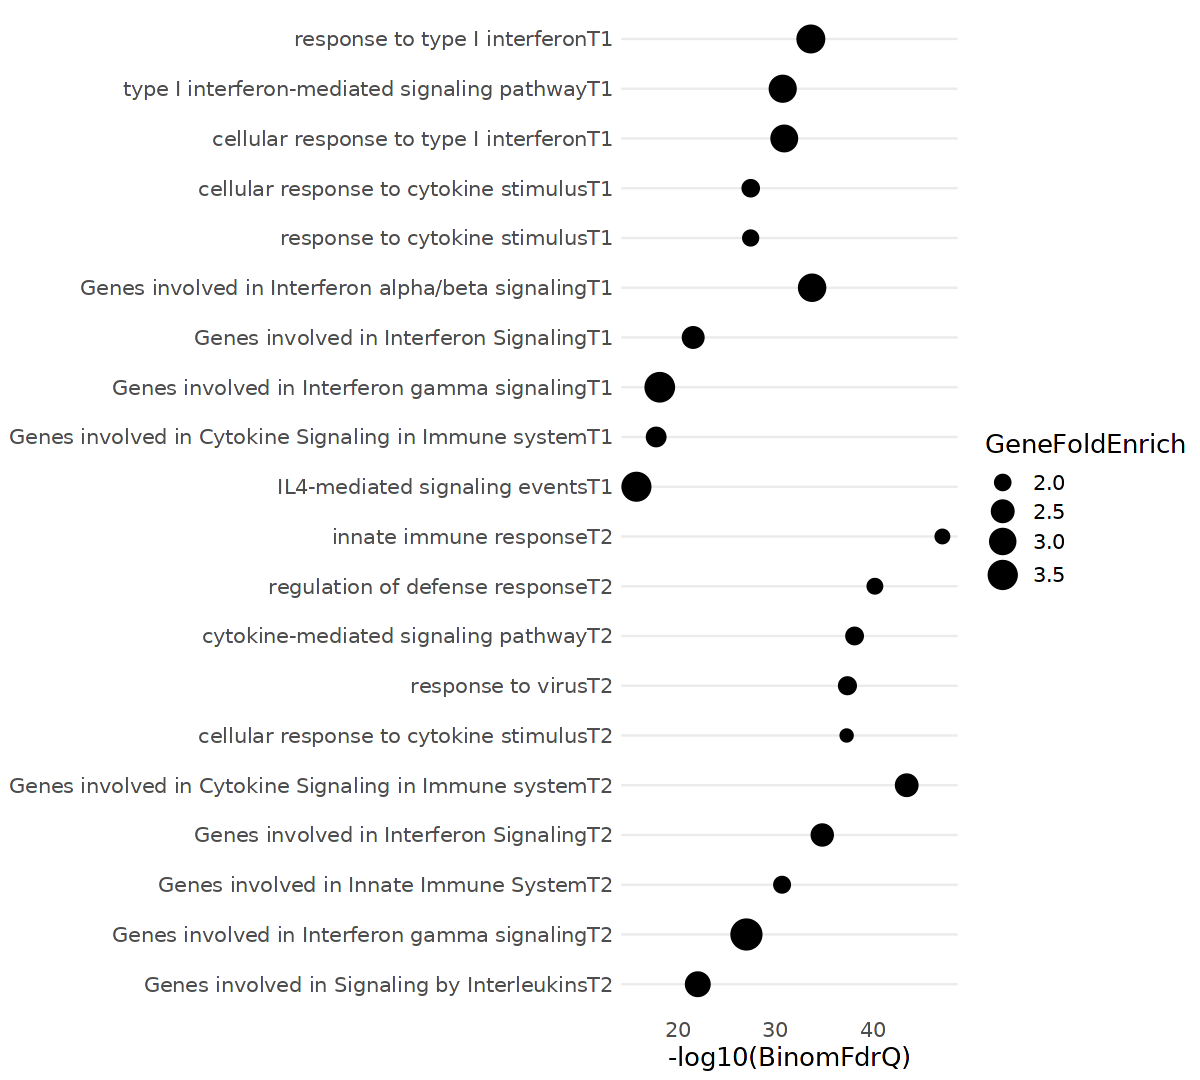

In [32]:
# Prepare the data, format q value
top_desc_per_group <- great_results %>%
  group_by(Ontology) %>%
  mutate(neg_log10_BinomFdrQ = -log10(BinomFdrQ))
top_desc_per_group$Desc = factor(top_desc_per_group$Desc, levels = rev(top_desc_per_group$Desc))

# Plot
options(repr.plot.width = 10, repr.plot.height = 9)
ggplot(data = top_desc_per_group, aes(x = Desc, y = neg_log10_BinomFdrQ, size = GeneFoldEnrich)) +
  geom_point(color = "black") +
  theme_minimal() +
  labs(y = "-log10(BinomFdrQ)") +
  coord_flip() +
  scale_size_continuous(range = c(3, 8)) +
  theme(
    axis.title.y = element_blank(),
    text = element_text(size = 15),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank()
  )

# Figure 4D:

## TE accessibility based UMAP

Create seurat object containing cells that passed peak-level QC and were quantified by scTE

In [ ]:
# Get peak-based cell type annotation and barcodes passing peak-based QC
allcells = readRDS('allcells/seurat_obj/integrated_allcohorts_seuratobj_geneactivity_lsi_metadata_qc_motifs_annotated_detailed.rds')
celltype_metadata = allcells@meta.data
## Peak-QC passing barcodes
allcellsqc_barcodes = row.names(allcells@meta.data %>% filter(broad_celltype_excluded != 'Excluded'))
rm(allcells)

# Read in TE counts matrix
te_counts = read.table('scte/preprocessing/unfiltered_combined_scte.txt', sep = '\t', header = TRUE, check.names = FALSE)
colnames(te_counts) <- gsub("\\.", "-", colnames(te_counts))
colnames(te_counts) <- gsub("_", ".", colnames(te_counts))
row.names(te_counts) = te_counts$barcodes
te_barcodes = te_counts$barcodes

# Define a set of barcodes that passed peak-based QC and have TE's quantified, subset counts matrix by these
peakqc_tecounts_barcodes = intersect(allcellsqc_barcodes, te_barcodes)
te_countsqc = te_counts %>% filter(barcodes %in% peakqc_tecounts_barcodes) 
te_countsqc$barcodes = NULL
te_countsqc = data.frame(t(te_countsqc), check.names = FALSE)

# Create seurat object, log normalize data
te_obj = CreateSeuratObject(counts = te_countsqc, assay = 'scte', meta.data = celltype_metadata, min.cells = 10, min.features = 200)
te_obj <- NormalizeData(
   object = te_obj,
  assay = 'scte',
  normalization.method = 'LogNormalize',
    scale.factor = median(te_obj$nCount_scte)
)

Scale and run PCA

In [ ]:
all.genes <- rownames(te_obj)
te_obj <- ScaleData(te_obj, features = all.genes)
te_obj = RunPCA(te_obj, features =all.genes)

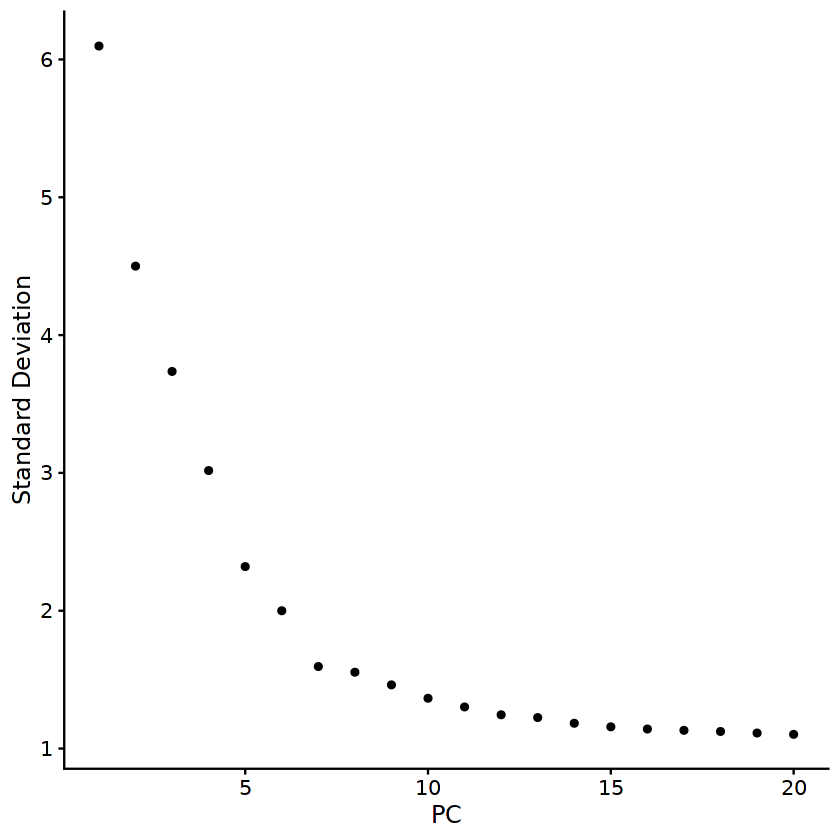

In [5]:
# Determine number of PCs
ElbowPlot(te_obj)

Clustering and UMAP

In [6]:
te_obj <- FindNeighbors(te_obj, dims = 1:15)
te_obj <- FindClusters(te_obj, resolution = 0.1)
te_obj <- RunUMAP(te_obj, dims = 1:15)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 156867
Number of edges: 4133366

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9588
Number of communities: 8
Elapsed time: 132 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
19:11:45 UMAP embedding parameters a = 0.9922 b = 1.112

19:11:45 Read 156867 rows and found 15 numeric columns

19:11:45 Using Annoy for neighbor search, n_neighbors = 30

19:11:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:12:06 Writing NN index file to temp file /tmp/Rtmp907XUC/file7d68904671

19:12:06 Searching Annoy index using 1 thread, search_k = 3000

19:13:20 Annoy recall = 100%

19:13:22 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

Mapping cell types to major lineages

In [7]:
# Mapping cell types to major lineages
lineage <- te_obj@meta.data %>%
  mutate(major_lineage = case_when(
    broad_celltype_excluded %in% c("Tumor") ~ "tumor",
    broad_celltype_excluded %in% c("TAM", "Monocyte", "MoDC", "cDC") ~ "myeloid",
    broad_celltype_excluded %in% c("CD8 T cell", "NK", "T-helper", "B cell", "Plasma cell", "T-reg") ~ "lymphoid",
    broad_celltype_excluded %in% c("Endothelial", "Perivascular cell", "Fibroblast") ~ "stromal",
    TRUE ~ as.character(broad_celltype_excluded) # Default case to keep original value if not matched
  ))
te_obj = AddMetaData(te_obj, lineage)

Plot TE UMAP using peak-based cell type labels

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



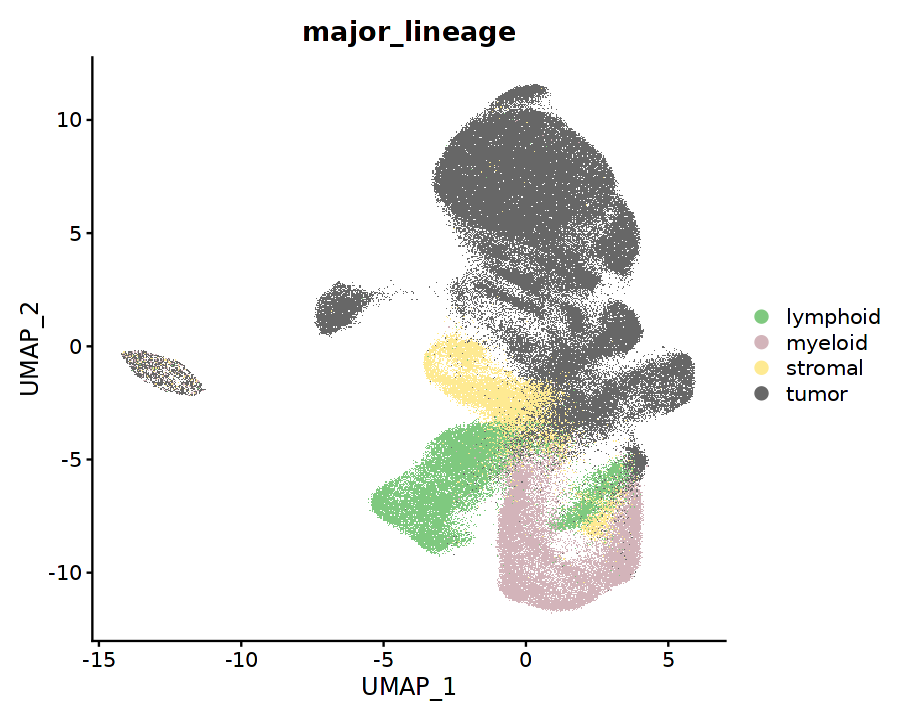

In [13]:
sample_cols <- colorRampPalette(brewer.pal(5, "Accent"))(4)
sample_cols = sample_cols[-4]
sample_cols = c(sample_cols, '#676767')

options(repr.plot.width=7.5, repr.plot.height=6)
DimPlot(te_obj, reduction = "umap", group.by = 'major_lineage', cols = sample_cols)

## HERVE.int accessibility between tumor and non-tumor cells

Set metadata column with identities

In [14]:
te_obj$tumor = ifelse(te_obj$broad_celltype_excluded == 'Tumor', 'Tumor', 'Non-tumor')
te_obj$HERVE.int = te_obj@assays$scte@data['HERVE-int',]
te_obj$tumor = factor(te_obj$tumor, levels = c('Tumor', 'Non-tumor'))

Plot HERVE.int accessibility per biopsy, split by mutation status. 

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"


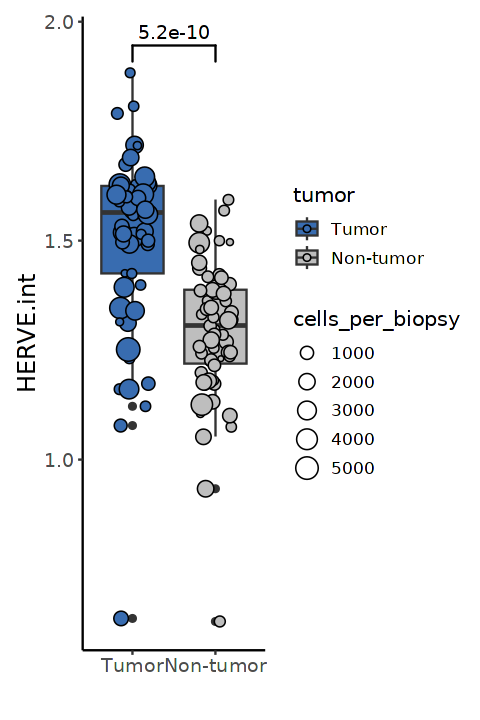

In [18]:
options(repr.plot.width=4, repr.plot.height=6)
sample_cols <- colorRampPalette(brewer.pal(5, "Accent"))(4)
plot_signature_by_mutation(te_obj@meta.data, 'tumor', 'HERVE.int')+
    geom_signif(comparisons = list(c('Non-tumor', 'Tumor')),test.args=list(alternative = "less")) + xlab("")+
    scale_fill_manual(values = c(sample_cols[4],'grey'))


# Figure 4E: ERV accessibility and IFN signaling

Create a ccRCC tumor seurat object that has both:
- ATAC data for calculating IFN1 and IFNG peak signature scores
- TE data for ERV accessibility data

In [ ]:
# load in ccrcc object and subset to cells that also have TE counts
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_wchromvar_Oct2023.rds')
incommon = intersect(row.names(ccrcc@meta.data), row.names(te_obj@meta.data))
ccrcc_te_atac = subset(ccrcc, cells = incommon)

# subset TE object to ccRCC tumor cells
ccrcc_te_obj = subset(te_obj, cells = row.names(ccrcc@meta.data))

# add TE assay to ccRCC ATAC object to create an object that stores both types of data
ccrcc_te_atac[['scte']] <- ccrcc_te_obj[['scte']]

Signature scoring with IFN1 and IFNG-associated peak sets

In [18]:
ifn1_me = readRDS('scte/cytosig/ifn1_sample_fivep_mixedeffects_assoc_peaks.RDS')
ifn1_me$p.value = ifn1_me[,5]
ifn1_me$feature = as.character(ifn1_me$feature)
ifn1_me_sig = ifn1_me %>% filter((p.value < 0.05) & (Estimate > 0))
DefaultAssay(ccrcc_te_atac) = 'ATAC'
sig = calculate_signature_scores(seurat_object = ccrcc_te_atac, sig_peak_set = ifn1_me_sig$feature, pct.open = 0.05, final_score_name = 'IFN1_ATAC')
ccrcc_te_atac = AddMetaData(ccrcc_te_atac, metadata = sig)

ifng_me = readRDS('scte/cytosig/ifng_sample_fivep_mixedeffects_assoc_peaks.RDS')
ifng_me$p.value = ifng_me[,5]
ifng_me$feature = as.character(ifng_me$feature)
ifng_me_sig = ifng_me %>% filter((p.value < 0.05) & (Estimate > 0))
sig = calculate_signature_scores(seurat_object = ccrcc_te_atac, sig_peak_set = ifng_me_sig$feature, pct.open = 0.05, final_score_name = 'IFNG_ATAC')
ccrcc_te_atac = AddMetaData(ccrcc_te_atac, metadata = sig)

Matching GC.percent distribution

Matching GC.percent distribution



Extract ERV names to loop over in model

In [19]:
ervs_features = row.names(ccrcc_te_atac@assays$scte@data)[grepl('HERV|ERV',row.names(ccrcc_te_atac@assays$scte@data))]
length(ervs_features)

[1] 58

Identify ERVs associated with IFN1 signaling. Results in Supp table 4, sheet F. 

In [20]:
df_list = list()
k = 0
for (i in 1:length(ervs_features)) {
    
    # Variables for model
    ft = ervs_features[i]
    te_accessibility = ccrcc_te_atac@assays$scte@data[ft,]
    ifn1_score = ccrcc_te_atac@meta.data$IFN1_ATAC
    seq_depth = ccrcc_te_atac@meta.data$nCount_ATAC
    sample = ccrcc_te_atac@meta.data$sample
    
    # Ensure the variables are in a data frame for lmer
    data_for_model <- data.frame(te_accessibility, ifn1_score, seq_depth, sample)
    
    if (!all(te_accessibility == 0)) {
        k = k + 1
        # Fit a mixed effects model
        model = lmer(ifn1_score ~ te_accessibility + seq_depth + (1|sample), data = data_for_model)

        # Extract coefficients for fixed effects
        summary_model <- summary(model)
        fixed_effects <- summary_model$coefficients[2,] # Assuming you're still interested in the 'ifn1_score' and 'seq_depth'

        # Create a data frame to store results, including the feature name
        df = data.frame(t(data.frame(fixed_effects)), check.names = FALSE)
        df$feature = ft

        df_list[[k]] = df  
    }

}

# Combine, adjust p value and subset to significant results
results = bind_rows(df_list)
results$p.adjust = p.adjust(results[,5], method = 'BH')
ifn1_results = results
ifn1_sig_results = results %>% filter((p.adjust < 0.05) & (Estimate > 0))

Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scale

Identify ERVs associated with IFNG signaling. Results in Supp table 4, sheet F. 

In [21]:
df_list = list()
k = 0
for (i in 1:length(ervs_features)) {
    
    # Variables for model
    ft = ervs_features[i]
    te_accessibility = ccrcc_te_atac@assays$scte@data[ft,]
    ifng_score = ccrcc_te_atac@meta.data$IFNG_ATAC
    seq_depth = ccrcc_te_atac@meta.data$nCount_ATAC
    sample = ccrcc_te_atac@meta.data$sample
    
    # Ensure the variables are in a data frame for lmer
    data_for_model <- data.frame(te_accessibility, ifng_score, seq_depth, sample)
    
    if (!all(te_accessibility == 0)) {
        k = k + 1
        # Fit a mixed effects model
        model = lmer(ifng_score ~ te_accessibility + seq_depth + (1|sample), data = data_for_model)

        # Extract coefficients for fixed effects
        summary_model <- summary(model)
        fixed_effects <- summary_model$coefficients[2,] # Assuming you're still interested in the 'ifng_score' and 'seq_depth'

        # Create a data frame to store results, including the feature name
        df = data.frame(t(data.frame(fixed_effects)), check.names = FALSE)
        df$feature = ft

        df_list[[k]] = df  
    }

}

# Combine, adjust p value and subset to significant results
results = bind_rows(df_list)
results$p.adjust = p.adjust(results[,5], method = 'BH')
ifng_results = results
ifng_sig_results = results %>% filter((p.adjust < 0.05) & (Estimate > 0))
ifng_sig_results

Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scales: consider rescaling"
Warning message:
"Some predictor variables are on very different scale

,Estimate,Std. Error,df,t value,Pr(>|t|),feature,p.adjust
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
fixed_effects...1,0.0009017277,0.0001760800,82521.21,5.121127,3.043968e-07,ERV24B.Prim-int,1.103438e-06
fixed_effects...2,0.0013293866,0.0002713460,82530.66,4.899230,9.639481e-07,ERV3-16A3.I-int,2.942578e-06
fixed_effects...3,0.0015947882,0.0001597726,82522.32,9.981614,1.891682e-23,ERV3-16A3.LTR,1.371470e-22
fixed_effects...4,0.0012002219,0.0002851766,82530.18,4.208698,2.571182e-05,ERVL-E-int,7.101360e-05
fixed_effects...5,0.0015091769,0.0002117346,82520.56,7.127680,1.029068e-12,ERVL47-int,5.425994e-12
fixed_effects...6,0.0019581015,0.0001550902,82524.50,12.625564,1.650003e-36,HERV15-int,1.367145e-35
fixed_effects...7,0.0025240536,0.0001518081,82523.32,16.626606,5.643706e-62,HERV3-int,1.091116e-60
fixed_effects...8,0.0016561132,0.0001684520,82523.30,9.831368,8.490596e-23,HERV9N-int,5.471717e-22
fixed_effects...9,0.0008694289,0.0001557336,82525.21,5.582797,2.374220e-08,HERVE-int,9.180317e-08


**Plot the combined results**

In [22]:
ifn1_sig_results$group = 'IFN1'
ifng_sig_results$group = 'IFNG'

ifn_sig_results = dplyr::bind_rows(list(ifn1_sig_results, ifng_sig_results))
write.table(ifn_sig_results, '../../snatac-rcc-manuscript-data/s4f_erv_ifn_associations.txt', sep = '\t', quote = F, row.names = F, col.names = T)

Warning message:
"Removed 20 rows containing missing values (`geom_point()`)."


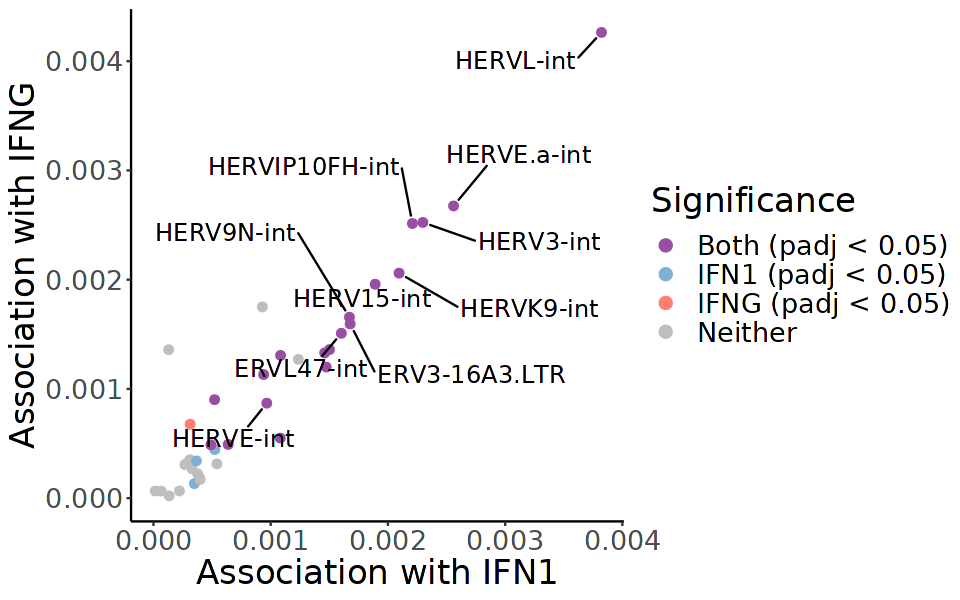

In [12]:
ifn1_results$Source <- 'IFN1'
ifng_results$Source <- 'IFNG'

# Join results and determine significance in which group(s)
df_combined <- merge(ifn1_results, ifng_results, by="feature", all=TRUE, suffixes=c("_IFN1", "_IFNG"))
df_combined$Significance <- ifelse(df_combined$p.adjust_IFN1 < 0.05 & df_combined$p.adjust_IFNG < 0.05, "Both (padj < 0.05)",
                                   ifelse(df_combined$p.adjust_IFN1 < 0.05, "IFN1 (padj < 0.05)",
                                          ifelse(df_combined$p.adjust_IFNG < 0.05, "IFNG (padj < 0.05)", "Neither")))

# Base plot
options(repr.plot.width=8, repr.plot.height=5)
p <- ggplot(df_combined, aes(x=Estimate_IFN1, y=Estimate_IFNG)) +
  geom_point(aes(color=Significance, size=Significance), alpha=1) +
  scale_size_manual(values=c("Both (padj < 0.05)"=2, "IFN1 (padj < 0.05)"=2, "IFNG (padj < 0.05)"=2, "Neither"=2)) +
  scale_color_manual(values=c("Both (padj < 0.05)"="#984ea3", "IFN1 (padj < 0.05)"="#80b1d3", "IFNG (padj < 0.05)"="#fb8072", "Neither"="grey")) +
  theme_classic() +
  labs(
       x="Association with IFN1",
       y="Association with IFNG",
       color="Significance", size="Significance") +
  guides(colour = guide_legend(override.aes = list(size=3))) +
  theme(text = element_text(size = 20))

# Identify top significant positive associations for both IFN1 and IFNG, plus the specific ERV
top_sig_pos_associations <- df_combined %>%
  filter(Significance == "Both (padj < 0.05)", Estimate_IFN1 > 0, Estimate_IFNG > 0) %>%
  arrange(p.adjust_IFN1 + p.adjust_IFNG) %>%
  top_n(-10, wt = p.adjust_IFN1 + p.adjust_IFNG) %>%
  bind_rows(filter(df_combined, feature == "ERV3.16A3-LTR")) %>%
  distinct(feature, .keep_all = TRUE)

# Annotate the top positive significant associations and the specific ERV
p <- p + geom_text_repel(data=top_sig_pos_associations, aes(label=feature),
                         size=5, box.padding = 1, point.padding = 0.5,
                         segment.color = 'black', max.overlaps = 50)
options(repr.plot.width=8, repr.plot.height=5)
p + ylim(0,NA) + xlim(0, NA)


# Figure 4F: ERV3.16A3-LTR accessibility BAP1 mt vs wt (tumor) vs immune

Get pLOF mutation info per sample. Same as in manuscript-figure3 for figure 3E. 

In [19]:
sample_biopsy_mapping = te_obj@meta.data %>% dplyr::select(sample,biopsy) %>% distinct()
mutations = read.table('../../snatac-rcc-manuscript-data/comut_muts.txt', sep = '\t')
mutations_filtered = mutations %>% filter(!(value %in% c('Missense','In frame indel', 'Unable to determine')))
combined_muts_bysample = dplyr::left_join(mutations_filtered, sample_biopsy_mapping, by = 'biopsy')

Warning message in dplyr::left_join(mutations_filtered, sample_biopsy_mapping, by = "biopsy"):
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 26 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


Create mutation matrix to add to Seurat object's metadata

In [20]:
# Create starter matrix based off of samples w/ mutations
mutation_matrix = combined_muts_bysample %>% dplyr::select(c('sample','category')) %>%
  tidyr::pivot_wider(names_from = category, values_from = category, values_fn = length, values_fill = 0)
sampleids = unique(te_obj$sample)

# Samples with no mutation info should be NAs
no_mut_data = c('rcc_0600855_T2', 'rcc_0600920_T1','rcc_RCCT1324-T1A')
missing_rows <- data.frame(sample = no_mut_data)
missing_rows[, unique(colnames(mutation_matrix)[-1])] <- NA

# If a sample did get sequencing but no mutations are found the entry should be 0
new_rows <- data.frame(sample = setdiff(sampleids, c(mutation_matrix$sample, no_mut_data)))
new_rows[, unique(colnames(mutation_matrix)[-1])] <- 0

# Concatenate together
mutation_matrix <- rbind(mutation_matrix, missing_rows, new_rows)

# Set column names that will be in metadata
colnames(mutation_matrix) = c('sample','SETD2_LOF', 'KDM5C_LOF','VHL_LOF','BAP1_LOF','PBRM1_LOF')

# Index by cell barcode and add to Seurat object
shared_states_lof = dplyr::left_join(te_obj@meta.data %>% dplyr::select('new_barcodes', 'sample'), mutation_matrix, by = 'sample')
row.names(shared_states_lof) = shared_states_lof$new_barcodes
shared_states_lof$new_barcodes = NULL
te_obj = AddMetaData(te_obj, shared_states_lof)

Subset to late stage ccRCC for this analysis. 

In [23]:
te_obj_latestage_ccrcc = subset(te_obj, subset = (stage %in% c('3','4')) & (histology == 'Clear cell'))

Set BAP1 mutation status

In [40]:
te_obj_latestage_ccrcc$BAP1_status <- dplyr::case_when(
  te_obj_latestage_ccrcc$BAP1_LOF == 1 ~ "BAP1_pLOF",
  te_obj_latestage_ccrcc$BAP1_LOF == 0 & te_obj_latestage_ccrcc$BAP1 == 1 ~ "Other", # non-pLOF mutation
  te_obj_latestage_ccrcc$BAP1_LOF == 0 ~ "BAP1_WT",
  TRUE ~ NA_character_ # No mutation information
)
table(te_obj_latestage_ccrcc$BAP1_status, useNA = 'ifany')


BAP1_pLOF   BAP1_WT     Other      <NA> 
    19932     44844      9103      8159 

Format groups to compare

In [42]:
# Label cells as in "ccrcc_balanced" annotation or "not_ccrcc_balanced"
te_obj_latestage_ccrcc$ccrcc_balanced <- ifelse(
  row.names(te_obj_latestage_ccrcc@meta.data) %in% row.names(ccrcc@meta.data),
  "ccrcc_balanced",
  "not_ccrcc_balanced"
)

# Identify immune-related cell types (CD45 positive)
excluded_celltypes <- c("Excluded", "Tumor", "Perivascular cell", "Endothelial", "Fibroblast")
cd45idents <- setdiff(unique(te_obj_latestage_ccrcc$broad_celltype_excluded), excluded_celltypes)

# Classify cells as "CD45", "Tumor", or "Other"
te_obj_latestage_ccrcc$tumor_cd45 <- dplyr::case_when(
  te_obj_latestage_ccrcc$broad_celltype_excluded %in% cd45idents ~ "CD45",
  te_obj_latestage_ccrcc$broad_celltype_excluded == "Tumor" ~ "Tumor",
  TRUE ~ "Other"
)

# Combine cell type and mutation status columns
te_obj_latestage_ccrcc$celltype_mutation <- paste0(
  te_obj_latestage_ccrcc$tumor_cd45, "_", te_obj_latestage_ccrcc$BAP1_status
)

# Summarize the results
celltype_mutation_table <- table(te_obj_latestage_ccrcc$celltype_mutation)
bap1_status_unique <- unique(te_obj_latestage_ccrcc$BAP1_status)
print(celltype_mutation_table)
print(bap1_status_unique)



 CD45_BAP1_pLOF    CD45_BAP1_WT         CD45_NA      CD45_Other Other_BAP1_pLOF 
           9090           10239            2073            1054             662 
  Other_BAP1_WT        Other_NA     Other_Other Tumor_BAP1_pLOF   Tumor_BAP1_WT 
           2999             692             245           10180           31606 
       Tumor_NA     Tumor_Other 
           5394            7804 
[1] "BAP1_WT"   "BAP1_pLOF" "Other"     NA         


Subset object to groups I would like to compare
e.g. All CD45 cells, BAP1 mutated tumor cells, BAP1 wt tumor cells

In [43]:
te_plotobj = subset(te_obj_latestage_ccrcc, subset = (celltype_mutation %in% c('Tumor_BAP1_pLOF', 'Tumor_BAP1_WT', 'CD45_BAP1_pLOF', 'CD45_BAP1_WT', 'CD45_Other')))
te_plotobj$group = ifelse(te_plotobj$tumor_cd45 == 'Tumor', te_plotobj$celltype_mutation,te_plotobj$tumor_cd45 )
te_plotobj$group = factor(te_plotobj$group, levels = c('Tumor_BAP1_pLOF', 'Tumor_BAP1_WT', 'CD45'))

In [49]:
te_plotobj$ERV3.16A3.LTR = te_plotobj@assays$scte@data['ERV3-16A3.LTR',]

- Tumor BAP1 pLOF vs tumor BAP1 WT: one sided, we are hypothesizing that pLOF is greater b/c of greater IFN signal
    - To note: it is significant with two-sided. but we weren't looking for "any difference", we had a clear question in one direction
- Tumor BAP1 pLOF vs immune: two sided, no hypothesis for direction
- Tumor BAP1 WT vs immune: two sided, no hypothesis for direction

In [50]:
# Calculate the median per biopsy
median_per_biop <- te_plotobj@meta.data %>%
  group_by(biopsy, group) %>%
  summarise(value = median(ERV3.16A3.LTR)) %>%
  arrange(-value)

# Perform the Wilcoxon tests
bap1mt_wt <- wilcox.test(
  (median_per_biop %>% filter(group == "Tumor_BAP1_pLOF"))$value,
  (median_per_biop %>% filter(group == "Tumor_BAP1_WT"))$value,
  alternative = "greater"
)$p.value

bap1mt_immune <- wilcox.test(
  (median_per_biop %>% filter(group == "Tumor_BAP1_pLOF"))$value,
  (median_per_biop %>% filter(group == "CD45"))$value
)$p.value

bap1wt_immune <- wilcox.test(
  (median_per_biop %>% filter(group == "Tumor_BAP1_WT"))$value,
  (median_per_biop %>% filter(group == "CD45"))$value
)$p.value

glue("Wilcoxon test p-value (Tumor_BAP1_pLOF vs Tumor_BAP1_WT): {formatC(bap1mt_wt, format = 'e', digits = 2)}")
glue("Wilcoxon test p-value (Tumor_BAP1_pLOF vs CD45): {formatC(bap1mt_immune, format = 'e', digits = 2)}")
glue("Wilcoxon test p-value (Tumor_BAP1_WT vs CD45): {formatC(bap1wt_immune, format = 'e', digits = 2)}")


`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.


Wilcoxon test p-value (Tumor_BAP1_pLOF vs Tumor_BAP1_WT): 1.00e-02

Wilcoxon test p-value (Tumor_BAP1_pLOF vs CD45): 7.76e-03

Wilcoxon test p-value (Tumor_BAP1_WT vs CD45): 9.63e-01

In [51]:
# Adjust Tumor_BAP1_pLOF vs Tumor_BAP1_WT for the 19 IFN-associated ERVs we considered
p.adjust(0.0100103199174407,n=19)

[1] 0.1901961

Plot

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed"


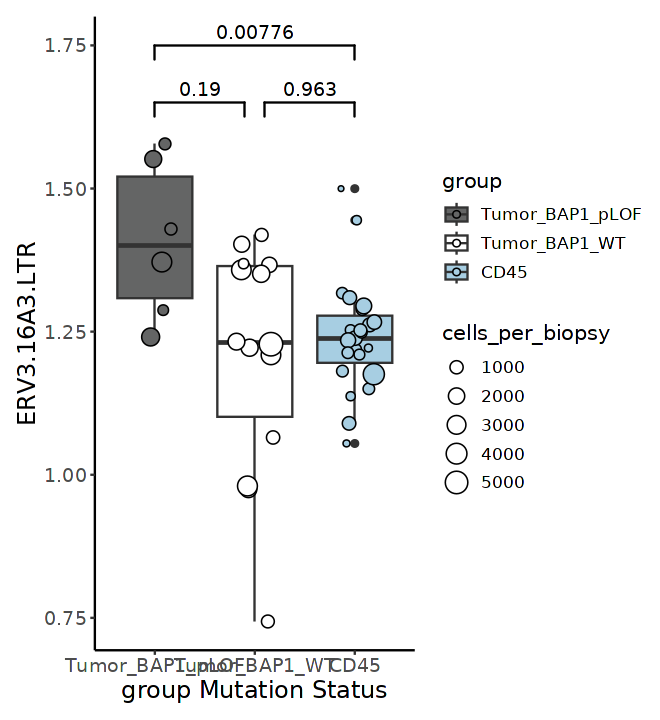

In [52]:
options(repr.plot.width=5.5, repr.plot.height=6)
plot_signature_by_mutation(data = te_plotobj@meta.data, mutation_column = "group", signature = 'ERV3.16A3.LTR') + scale_fill_manual(values = c('#646565', 'white','#A7CEE2')) +
geom_signif(
    y_position = c(1.65, 1.65, 1.75), xmin = c(1, 2.1, 1), xmax = c(1.9, 3, 3),
    annotation = c(formatC(p.adjust(bap1mt_wt, n = 19), digits = 3), formatC(bap1wt_immune, digits = 3), formatC(bap1mt_immune, digits = 3))
  )